In [78]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom

In [174]:
class Graph():
    '''
    A class to generate graphs.
    '''

    def __init__(self):
        '''
        Creates and empty graph.
        '''
        
        self.G = nx.Graph()

    def generateGraph(self, N, p, graphType, showGraph = False):
        '''
        Generates a chosen graph with N nodes and edges with probability p.
        Args:
        N - number of nodes
        p - probability of connection between two chosen nodes
        graphType - type of graph from: randomGraph using the Gilbert model, wattsStrogatz and barabasiAlbert
        showGraph - determines if graph is shown, the default is False
        '''
        
        if type(N) is not int:
            return 'N must be an integer'
        elif N < 0:
            return 'N must be a positive number'
        elif p < 0 or p > 1:
            return 'p must be between 0 and 1'
        
        if graphType == 'randomGraph':
            for i in range(N):
                self.G.add_node(i)

            for i in range(N):
                for j in range(N):
                    if i != j:
                        q = np.random.rand()
                        if q < p:
                            self.G.add_edge(i, j)

            if showGraph == True:
                nx.draw(self.G, node_size = 10, width = 0.3, node_color='black', edge_color='gray')
                plt.show()
        
        elif graphType == 'wattsStrogatz':
            pass
        
        elif graphType == 'barabasiAlbert':
            pass
        
        else:
            return 'You must choose a type of graph from: randomGraph, wattsStrogatz or barabasiAlbert'
            
        return self.G
    
    def numberOfVerticesAndEdges(self):
        '''
        Prints number of nodes and edges in the graph.
        '''
        
        print(f"Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()}")
        
    def averageDegree(self):
        """
        Calculates average degree of the nodes in the graph.
        """
        
        d = []
        for i in self.G.nodes:
            d.append(self.G.degree(i))
            
        print(f"Average degree is: {np.mean(d)}")
        return np.mean(d)


    def degreeDistributionVar(self):
        '''
        Calculates the variance of the degree distribution (binomial distribution) of a given graph.
        '''
        
        d = [d for n, d in self.G.degree()]
        
        print(f"Variance of a degree distribution: {np.var(d)}")
        return np.var(d)
    
    def frequencyPlot(self):
        '''
        Generates a frequency plot for the degree distribution of the given graph.
        '''
        
        histogram = nx.degree_histogram(self.G)
        ds = range(len(histogram))
        
        plt.bar(ds, histogram)
        plt.xlabel('# of Degrees')
        plt.ylabel('#')
        plt.title('Frequency plot for degrees')
        plt.show()
        
    def fitPoissonDistribution(self):
        '''
        Fits a Poisson distribution to the degree distribution of the given graph.
        '''
        
        d = [d for n, d in self.G.degree()]
        
        fittedModel = poisson(np.mean(d))
        
        histogram = nx.degree_histogram(self.G)
        ds = range(len(histogram))

        plt.bar(ds, histogram, label = 'Frequency plot for degrees')
        plt.plot(ds, len(d) * fittedModel.pmf(ds), 'r-', label = 'Fitted Poisson distribution')
        plt.xlabel('# of Degrees')
        plt.ylabel('#')
        plt.title('Fitted Poisson distribution for degree distribution')
        plt.legend()
        plt.show()
        
    def fitBinomialDistribution(self):
        '''
        Fits a binomial distribution to the degree distribution of the given graph.
        '''
        
        d = [d for n, d in self.G.degree()]
        
        p = np.mean(d) / (len(d) - 1)
        
        fittedModel = binom(len(d) - 1, p)
        
        histogram = nx.degree_histogram(self.G)
        ds = range(len(histogram))
        
        plt.bar(ds, histogram, label = 'Frequency plot for degrees')
        plt.plot(range(max(d)+1), fittedModel.pmf(range(max(d)+1)), 'r-', label = 'Fitted Binomial distribution')
        plt.xlabel('# of Degrees')
        plt.ylabel('#')
        plt.title('Fitted Binomial distribution for degree distribution')
        plt.legend()
        plt.show()


In [182]:
G = Graph()

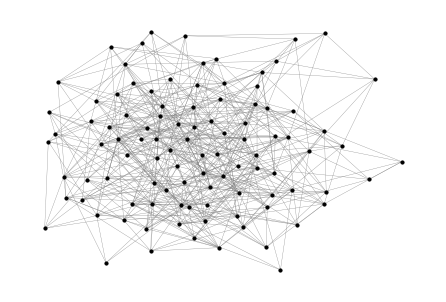

In [183]:
G.generateGraph(100, 0.05, 'randomGraph', True)

In [184]:
G.numberOfVerticesAndEdges()

Nodes: 100, Edges: 496


In [185]:
G.averageDegree()

Average degree is: 9.92


9.92

In [186]:
G.degreeDistributionVar()

Variance of a degree distribution: 7.353600000000001


7.353600000000001

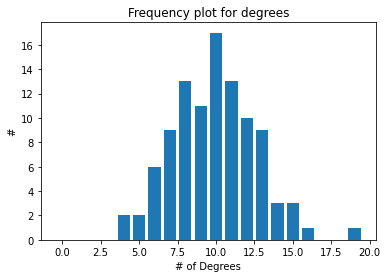

In [187]:
G.frequencyPlot()

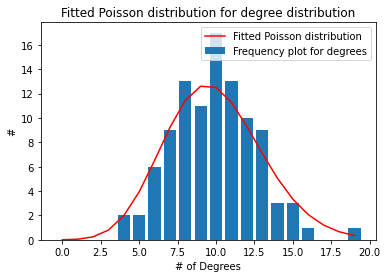

In [188]:
G.fitPoissonDistribution()

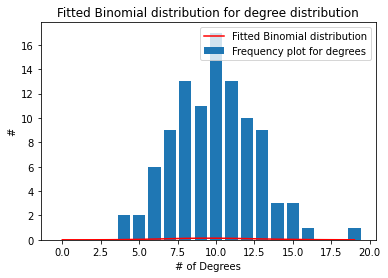

In [189]:
G.fitBinomialDistribution()